# Importing essential libraries

In [19]:
from __future__ import print_function, unicode_literals, absolute_import, division
import sys
import os
import time
import numpy as np
import pandas as pd
import matplotlib
import random
import math
import glob
matplotlib.rcParams["image.interpolation"] = 'none'
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
from collections import OrderedDict

import glob
from tqdm import tqdm
import tifffile
from tifffile import imread
from csbdeep.utils import Path, normalize

from stardist import fill_label_holes, random_label_cmap, calculate_extents, gputools_available
from stardist.plot import render_label
from stardist.matching import matching, matching_dataset
from stardist.models import Config2D, StarDist2D, StarDistData2D
from n2v.models import N2VConfig, N2V
from skimage.metrics import peak_signal_noise_ratio
from skimage.restoration import estimate_sigma
from sklearn.model_selection import train_test_split

np.random.seed(42)
lbl_cmap = random_label_cmap()

In [2]:
import psutil
print(f"Available RAM: {psutil.virtual_memory().available/1e9:.1f} GB")

Available RAM: 256.5 GB


In [3]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  0


E0000 00:00:1748342912.861802  679181 cuda_executor.cc:1228] INTERNAL: CUDA Runtime error: Failed call to cudaGetRuntimeVersion: Error loading CUDA libraries. GPU will not be used.: Error loading CUDA libraries. GPU will not be used.
W0000 00:00:1748342912.906920  679181 gpu_device.cc:2341] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


# Exploring the Images and their Noise profile

In [6]:
sample_img_path = "../Image_Data/E14.5_TOGF_noCre_data/Deconvolved_data/250410_12.43.29_LV_Ventral_500um_Current.cube.tif"

with tifffile.TiffFile(sample_img_path) as tif:
    memmap_stack = tif.asarray(out='memmap')
    print(f"Shape: {memmap_stack.shape}")

Shape: (506, 2048, 2048)


In [4]:
def frame_quality_metrics(tiff_path, num_samples=10):
    """Assess frame quality with adjustable sampling density"""
    with tifffile.TiffFile(tiff_path) as tif:
        memmap_stack = tif.asarray(out='memmap')
        total_frames = memmap_stack.shape[0]

    # Generate evenly spaced samples across entire stack
        sections = np.unique(np.linspace(0, total_frames-1, num=num_samples, dtype=int))
        sections = sections.tolist() + [-1]  # Always include last frame
        sections = sorted(np.unique(sections))  # Remove duplicates

        metrics = {}
        for z in sections:
            frame = memmap_stack[z]
            frame_mean = np.mean(frame)
            frame_std = np.std(frame)
            
            # Handle zero/std division
            snr = frame_mean / (frame_std + 1e-9)  # Add epsilon to avoid ÷0
            
            # Handle self-comparison PSNR
            if z == len(memmap_stack)-1:
                psnr_val = np.inf  # Or skip: psnr_val = None
            else:
                psnr_val = peak_signal_noise_ratio(frame, memmap_stack[-1])
            
            metrics[z] = {
                'mean': frame_mean,
                'std': frame_std,
                'snr': snr,
                'noise_level': estimate_sigma(frame, average_sigmas=True),
                'psnr_rel': psnr_val
            }
            
        return metrics

In [5]:
quality_report = frame_quality_metrics('../Image_Data/E14.5_TOGF_noCre_data/Deconvolved_data/250410_12.43.29_LV_Ventral_500um_Current.cube.tif')
print(f"Quality metrics:\n{quality_report}")

simple_metrics.py (168): divide by zero encountered in scalar divide


Quality metrics:
{-1: {'mean': 22.911126613616943, 'std': 44.77654710547996, 'snr': 0.5116769401430977, 'noise_level': 0.34582167542981557, 'psnr_rel': inf}, 0: {'mean': 2.0578110218048096, 'std': 100.76911237287139, 'snr': 0.020421049400236486, 'noise_level': 10.475748413003227, 'psnr_rel': 55.29536067219976}, 56: {'mean': 2769.3536179065704, 'std': 1948.783880365963, 'snr': 1.4210675928749428, 'noise_level': 1.686103496885505, 'psnr_rel': 25.776394708961114}, 112: {'mean': 2500.0680315494537, 'std': 1791.0216353351768, 'snr': 1.395889352883327, 'noise_level': 1.4892550966352154, 'psnr_rel': 26.622327718913986}, 168: {'mean': 2904.434943675995, 'std': 2201.8588658089748, 'snr': 1.3190831568614507, 'noise_level': 1.8714287741987867, 'psnr_rel': 25.14206758940365}, 224: {'mean': 2406.445858001709, 'std': 1910.1646159965928, 'snr': 1.2598107188499725, 'noise_level': 1.5752648571622383, 'psnr_rel': 26.631544985985293}, 280: {'mean': 2459.016726255417, 'std': 2270.8053569658546, 'snr': 1.0

In [8]:
def visualize_quality_metrics(metrics, tiff_path):
    """Visualization with dynamic labels"""
    with tifffile.TiffFile(tiff_path) as tif:
        memmap_stack = tif.asarray(out='memmap')
        total_frames = memmap_stack.shape[0]

    fig, axs = plt.subplots(4, 1, figsize=(12, 16))
    # First, convert the keys into actual indices for sorting
    z_indices = sorted(metrics.keys(), key=lambda z: total_frames - 1 if z == -1 else z)

    # Then, generate labels accordingly
    z_labels = [str(total_frames - 1) if z == -1 else str(z) for z in z_indices]
   
    # 1. Signal-to-Noise Ratio (SNR)
    snrs = [metrics[z]['snr'] for z in z_indices]
    axs[0].bar(z_labels, snrs, color='skyblue')
    axs[0].axhline(0.1, color='r', linestyle='--')
    axs[0].set_title(f"Signal-to-Noise Ratio (SNR)\n{tiff_path}")
    axs[0].set_ylabel("SNR")
    
    # 2. Noise Level (σ)
    noise_levels = [metrics[z]['noise_level'] for z in z_indices]
    axs[1].bar(z_labels, noise_levels, color='salmon')
    axs[1].set_title("Estimated Noise Level")
    axs[1].set_ylabel("σ")
    
    # 3. Mean Intensity
    means = [metrics[z]['mean'] for z in z_indices]
    axs[2].bar(z_labels, means, color='lightgreen')
    axs[2].set_title("Mean Intensity")
    axs[2].set_ylabel("Intensity (AU)")
    
    # 4. PSNR (exclude self-comparison)
    psnr_z = [z for z in z_indices if z != -1]  # Exclude last frame
    psnr_vals = [metrics[z]['psnr_rel'] for z in psnr_z]
    axs[3].bar([str(z) for z in psnr_z], psnr_vals, color='orchid')
    axs[3].set_title("PSNR Relative to Frame 505")
    axs[3].set_ylabel("PSNR (dB)")
    axs[3].set_xlabel("Z Position")
    
    plt.tight_layout()
    plt.show()

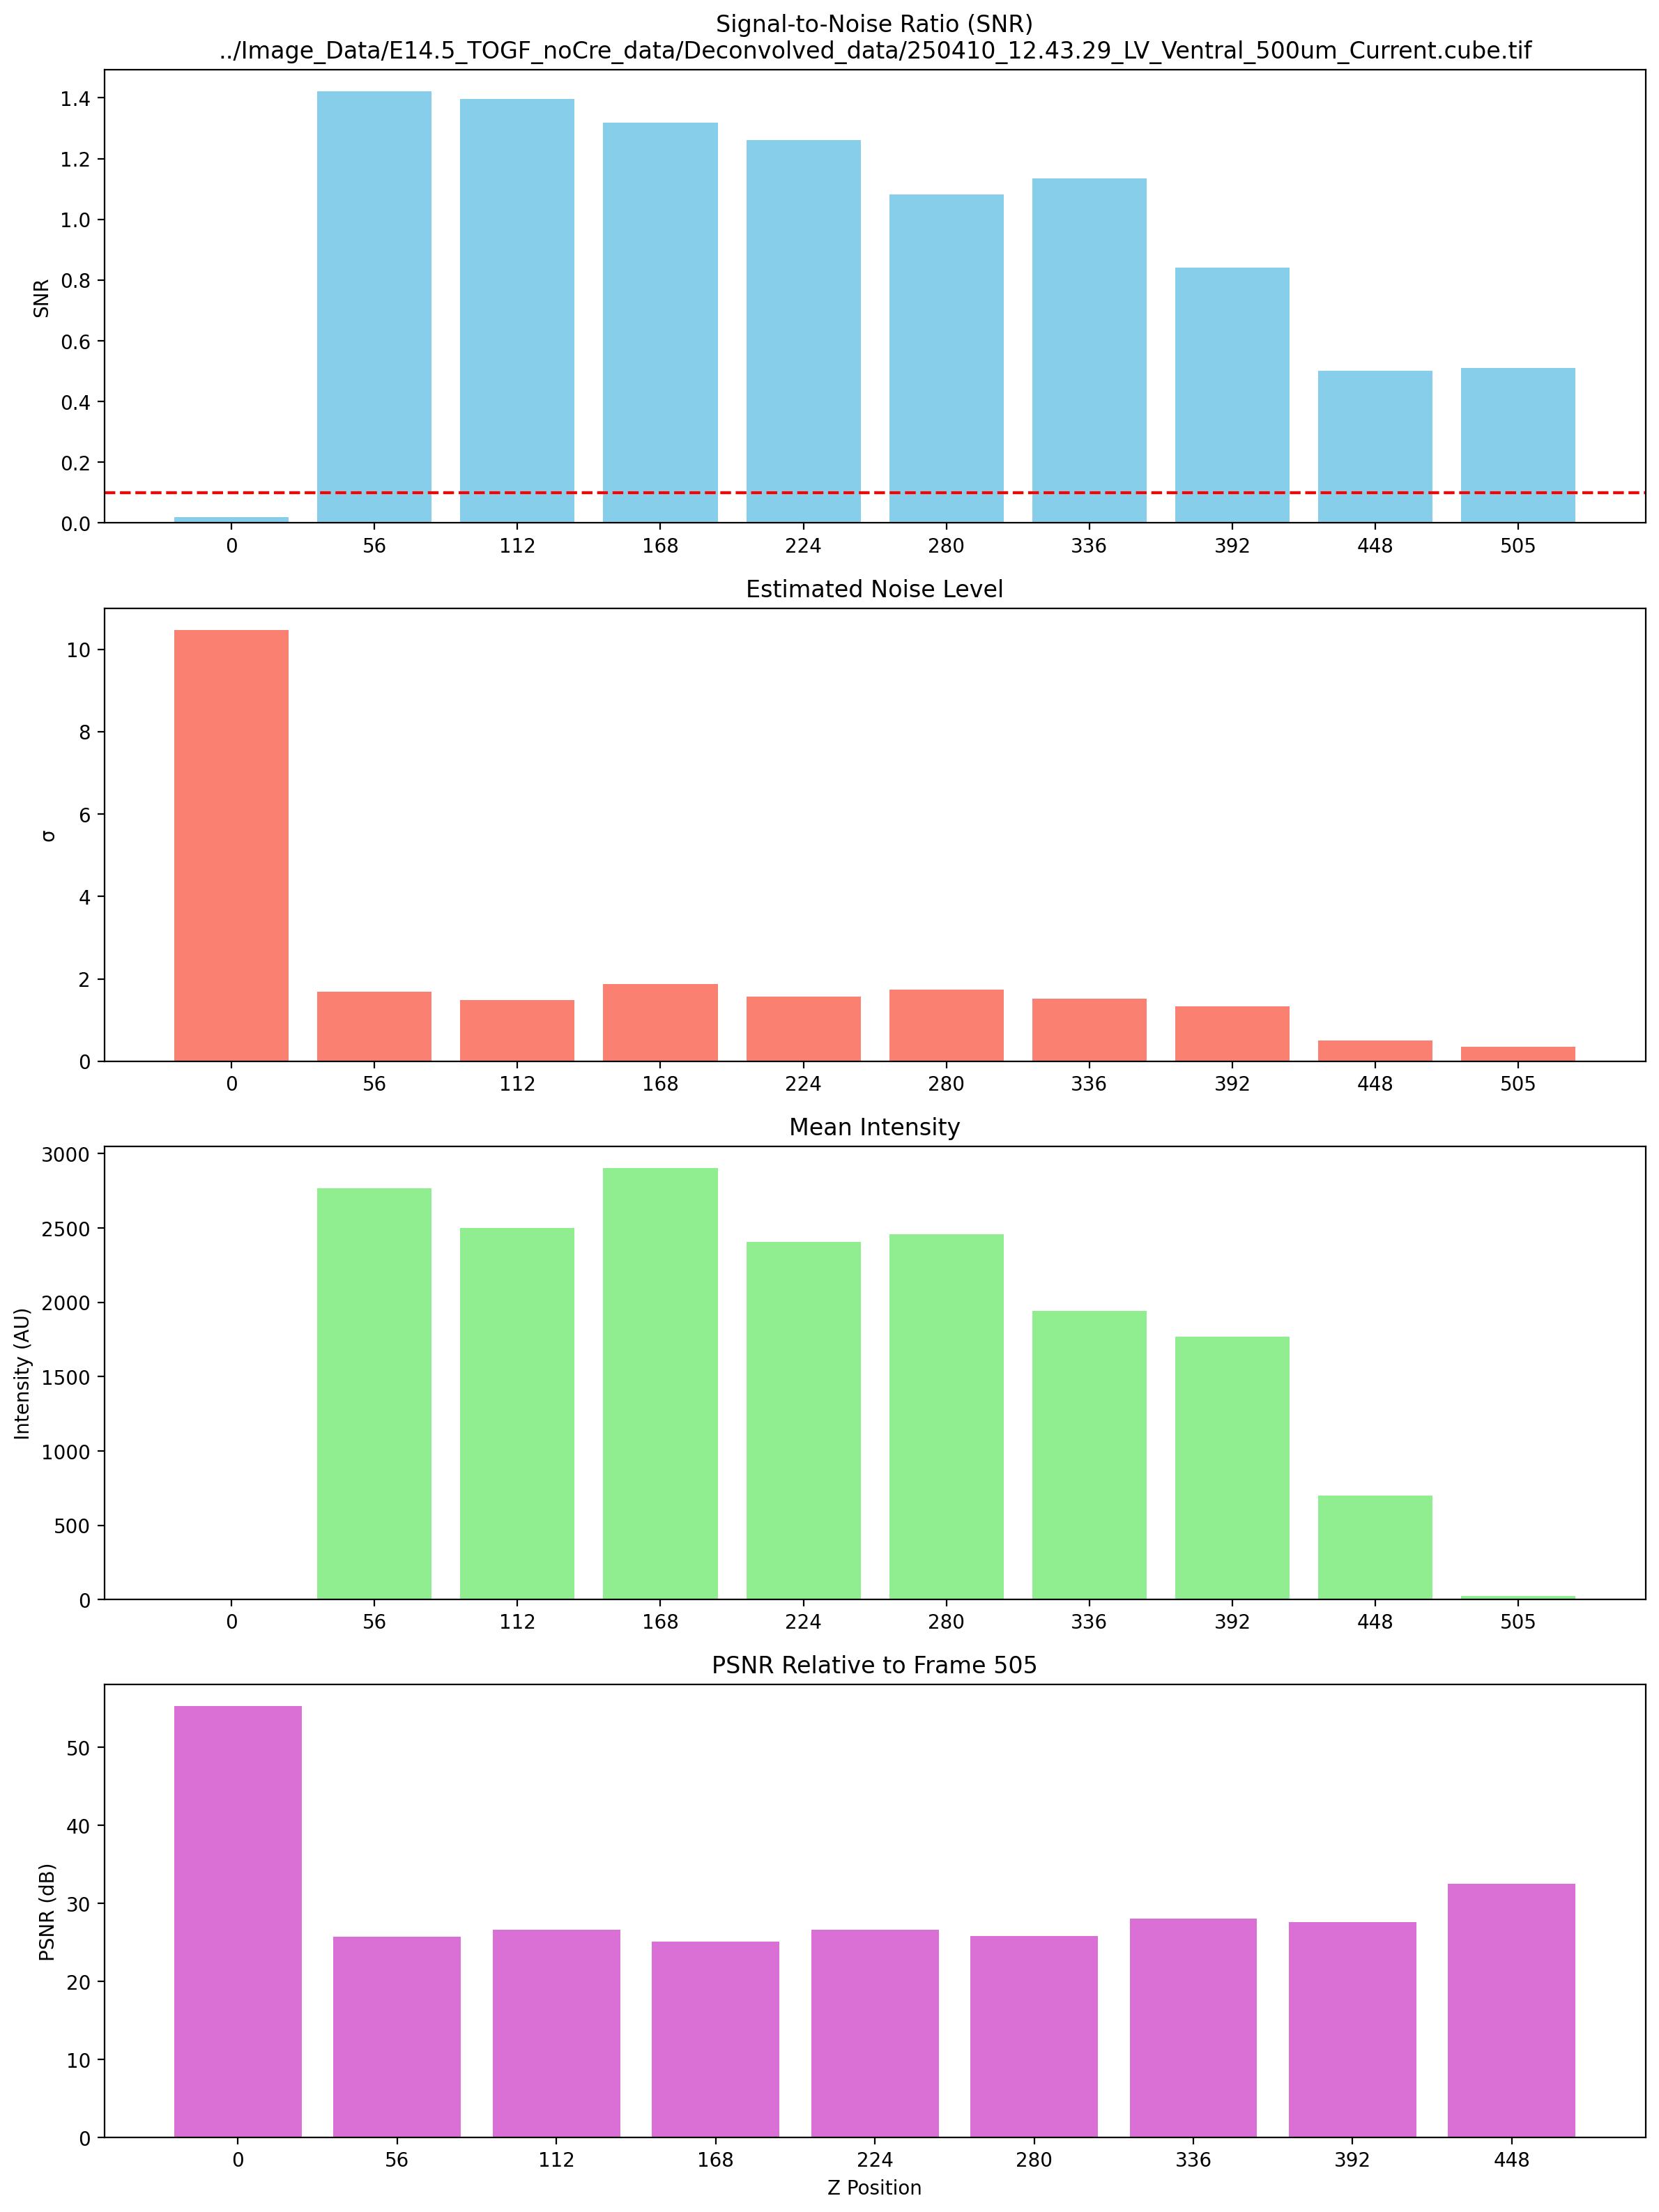

In [9]:
# Usage
visualize_quality_metrics(quality_report, '../Image_Data/E14.5_TOGF_noCre_data/Deconvolved_data/250410_12.43.29_LV_Ventral_500um_Current.cube.tif')

In [16]:
metrics_dict = OrderedDict()
total_frames_dict = {}
input_dir = "../Image_Data/E14.5_TOGF_noCre_data/Deconvolved_data/"

for filename in os.listdir(input_dir):
    if filename.endswith(".tif") or filename.endswith(".tiff"):
        path = os.path.join(input_dir, filename)
        metrics = frame_quality_metrics(path)
        metrics_dict[filename] = metrics
        with tifffile.TiffFile(path) as tif:
            total_frames_dict[filename] = tif.asarray(out='memmap').shape[0]

In [45]:
metrics_dict = OrderedDict()
total_frames_dict = OrderedDict()

input_dir = "../Image_Data/E14.5_TOGF_noCre_data/Deconvolved_data/"

start_time = time.time()

print(f"🔍 Scanning directory: {input_dir}")
tif_files = [f for f in os.listdir(input_dir) if f.endswith((".tif", ".tiff"))]

for filename in tqdm(tif_files, desc="📊 Processing images", unit="file"):
    path = os.path.join(input_dir, filename)
    try:
        metrics = frame_quality_metrics(path)
        metrics_dict[filename] = metrics

        with tifffile.TiffFile(path) as tif:
            total_frames_dict[filename] = tif.asarray(out='memmap').shape[0]

    except Exception as e:
        print(f"⚠️ Error processing {filename}: {e}")

end_time = time.time()
elapsed = end_time - start_time

print(f"\n✅ Done! Processed {len(metrics_dict)} images in {elapsed:.2f} seconds.")


🔍 Scanning directory: ../Image_Data/E14.5_TOGF_noCre_data/Deconvolved_data/


📊 Processing images: 100%|██████████| 4/4 [00:11<00:00,  3.00s/file]


✅ Done! Processed 4 images in 11.99 seconds.


In [20]:
list(metrics_dict.keys())

['250410_12.50.04_RV_Ventral_500um_Current.cube.tif',
 '250410_12.55.01_LA_Ventral_500um_Current.cube.tif',
 '250410_12.43.29_LV_Ventral_500um_Current.cube.tif',
 '250410_12.59.39_RA_Ventral_500um_Current.cube.tif']

In [21]:
def visualize_quality_metrics_multi(metrics_dict, total_frames_dict, max_cols=4):
    """
    Plot the same quality metrics side-by-side for multiple images.
    
    Args:
        metrics_dict (dict): {filename: metrics} from frame_quality_metrics.
        total_frames_dict (dict): {filename: total_frames}.
        max_cols (int): max number of images per row.
    """
    filenames = list(metrics_dict.keys())
    num_images = len(filenames)

    # Calculate rows and columns for subplots
    ncols = min(max_cols, num_images)
    nrows = math.ceil(num_images / ncols)

    fig, axs = plt.subplots(nrows * 4, ncols, figsize=(4 * ncols, 4 * nrows * 4), squeeze=False)
    fig.subplots_adjust(hspace=0.6, wspace=0.4)
    
    metric_names = ['snr', 'noise_level', 'mean', 'psnr_rel']
    metric_titles = [
        "Signal-to-Noise Ratio (SNR)",
        "Estimated Noise Level (σ)",
        "Mean Intensity (AU)",
        "PSNR Relative to Last Frame (dB)"
    ]
    colors = ['skyblue', 'salmon', 'lightgreen', 'orchid']

    for idx, filename in enumerate(filenames):
        metrics = metrics_dict[filename]
        total_frames = total_frames_dict[filename]

        # Sort keys with -1 replaced by last frame index
        z_indices = sorted(metrics.keys(), key=lambda z: total_frames - 1 if z == -1 else z)
        z_labels = [str(total_frames - 1) if z == -1 else str(z) for z in z_indices]

        col = idx % ncols
        row_base = (idx // ncols) * 4

        # 1. SNR
        snrs = [metrics[z]['snr'] for z in z_indices]
        axs[row_base][col].bar(z_labels, snrs, color=colors[0])
        axs[row_base][col].axhline(0.1, color='r', linestyle='--')
        axs[row_base][col].set_title(f"SNR\n{filename}", fontsize=10)
        axs[row_base][col].set_ylabel("SNR")
        axs[row_base][col].tick_params(axis='x', rotation=45)

        # 2. Noise Level
        noise_levels = [metrics[z]['noise_level'] for z in z_indices]
        axs[row_base+1][col].bar(z_labels, noise_levels, color=colors[1])
        axs[row_base+1][col].set_title("Estimated Noise Level (σ)", fontsize=10)
        axs[row_base+1][col].set_ylabel("σ")
        axs[row_base+1][col].tick_params(axis='x', rotation=45)

        # 3. Mean Intensity
        means = [metrics[z]['mean'] for z in z_indices]
        axs[row_base+2][col].bar(z_labels, means, color=colors[2])
        axs[row_base+2][col].set_title("Mean Intensity (AU)", fontsize=10)
        axs[row_base+2][col].set_ylabel("Intensity")
        axs[row_base+2][col].tick_params(axis='x', rotation=45)

        # 4. PSNR (exclude last frame)
        psnr_z = [z for z in z_indices if z != -1]
        psnr_vals = [metrics[z]['psnr_rel'] for z in psnr_z]
        axs[row_base+3][col].bar([str(z) for z in psnr_z], psnr_vals, color=colors[3])
        axs[row_base+3][col].set_title("PSNR Relative to Last Frame", fontsize=10)
        axs[row_base+3][col].set_ylabel("PSNR (dB)")
        axs[row_base+3][col].set_xlabel("Frame Index")
        axs[row_base+3][col].tick_params(axis='x', rotation=45)

    # Hide empty subplots if number of images < nrows * ncols
    total_subplots = nrows * ncols
    for empty_idx in range(num_images, total_subplots):
        col = empty_idx % ncols
        row_base = (empty_idx // ncols) * 4
        for i in range(4):
            axs[row_base + i][col].axis('off')

    plt.tight_layout()
    plt.show()


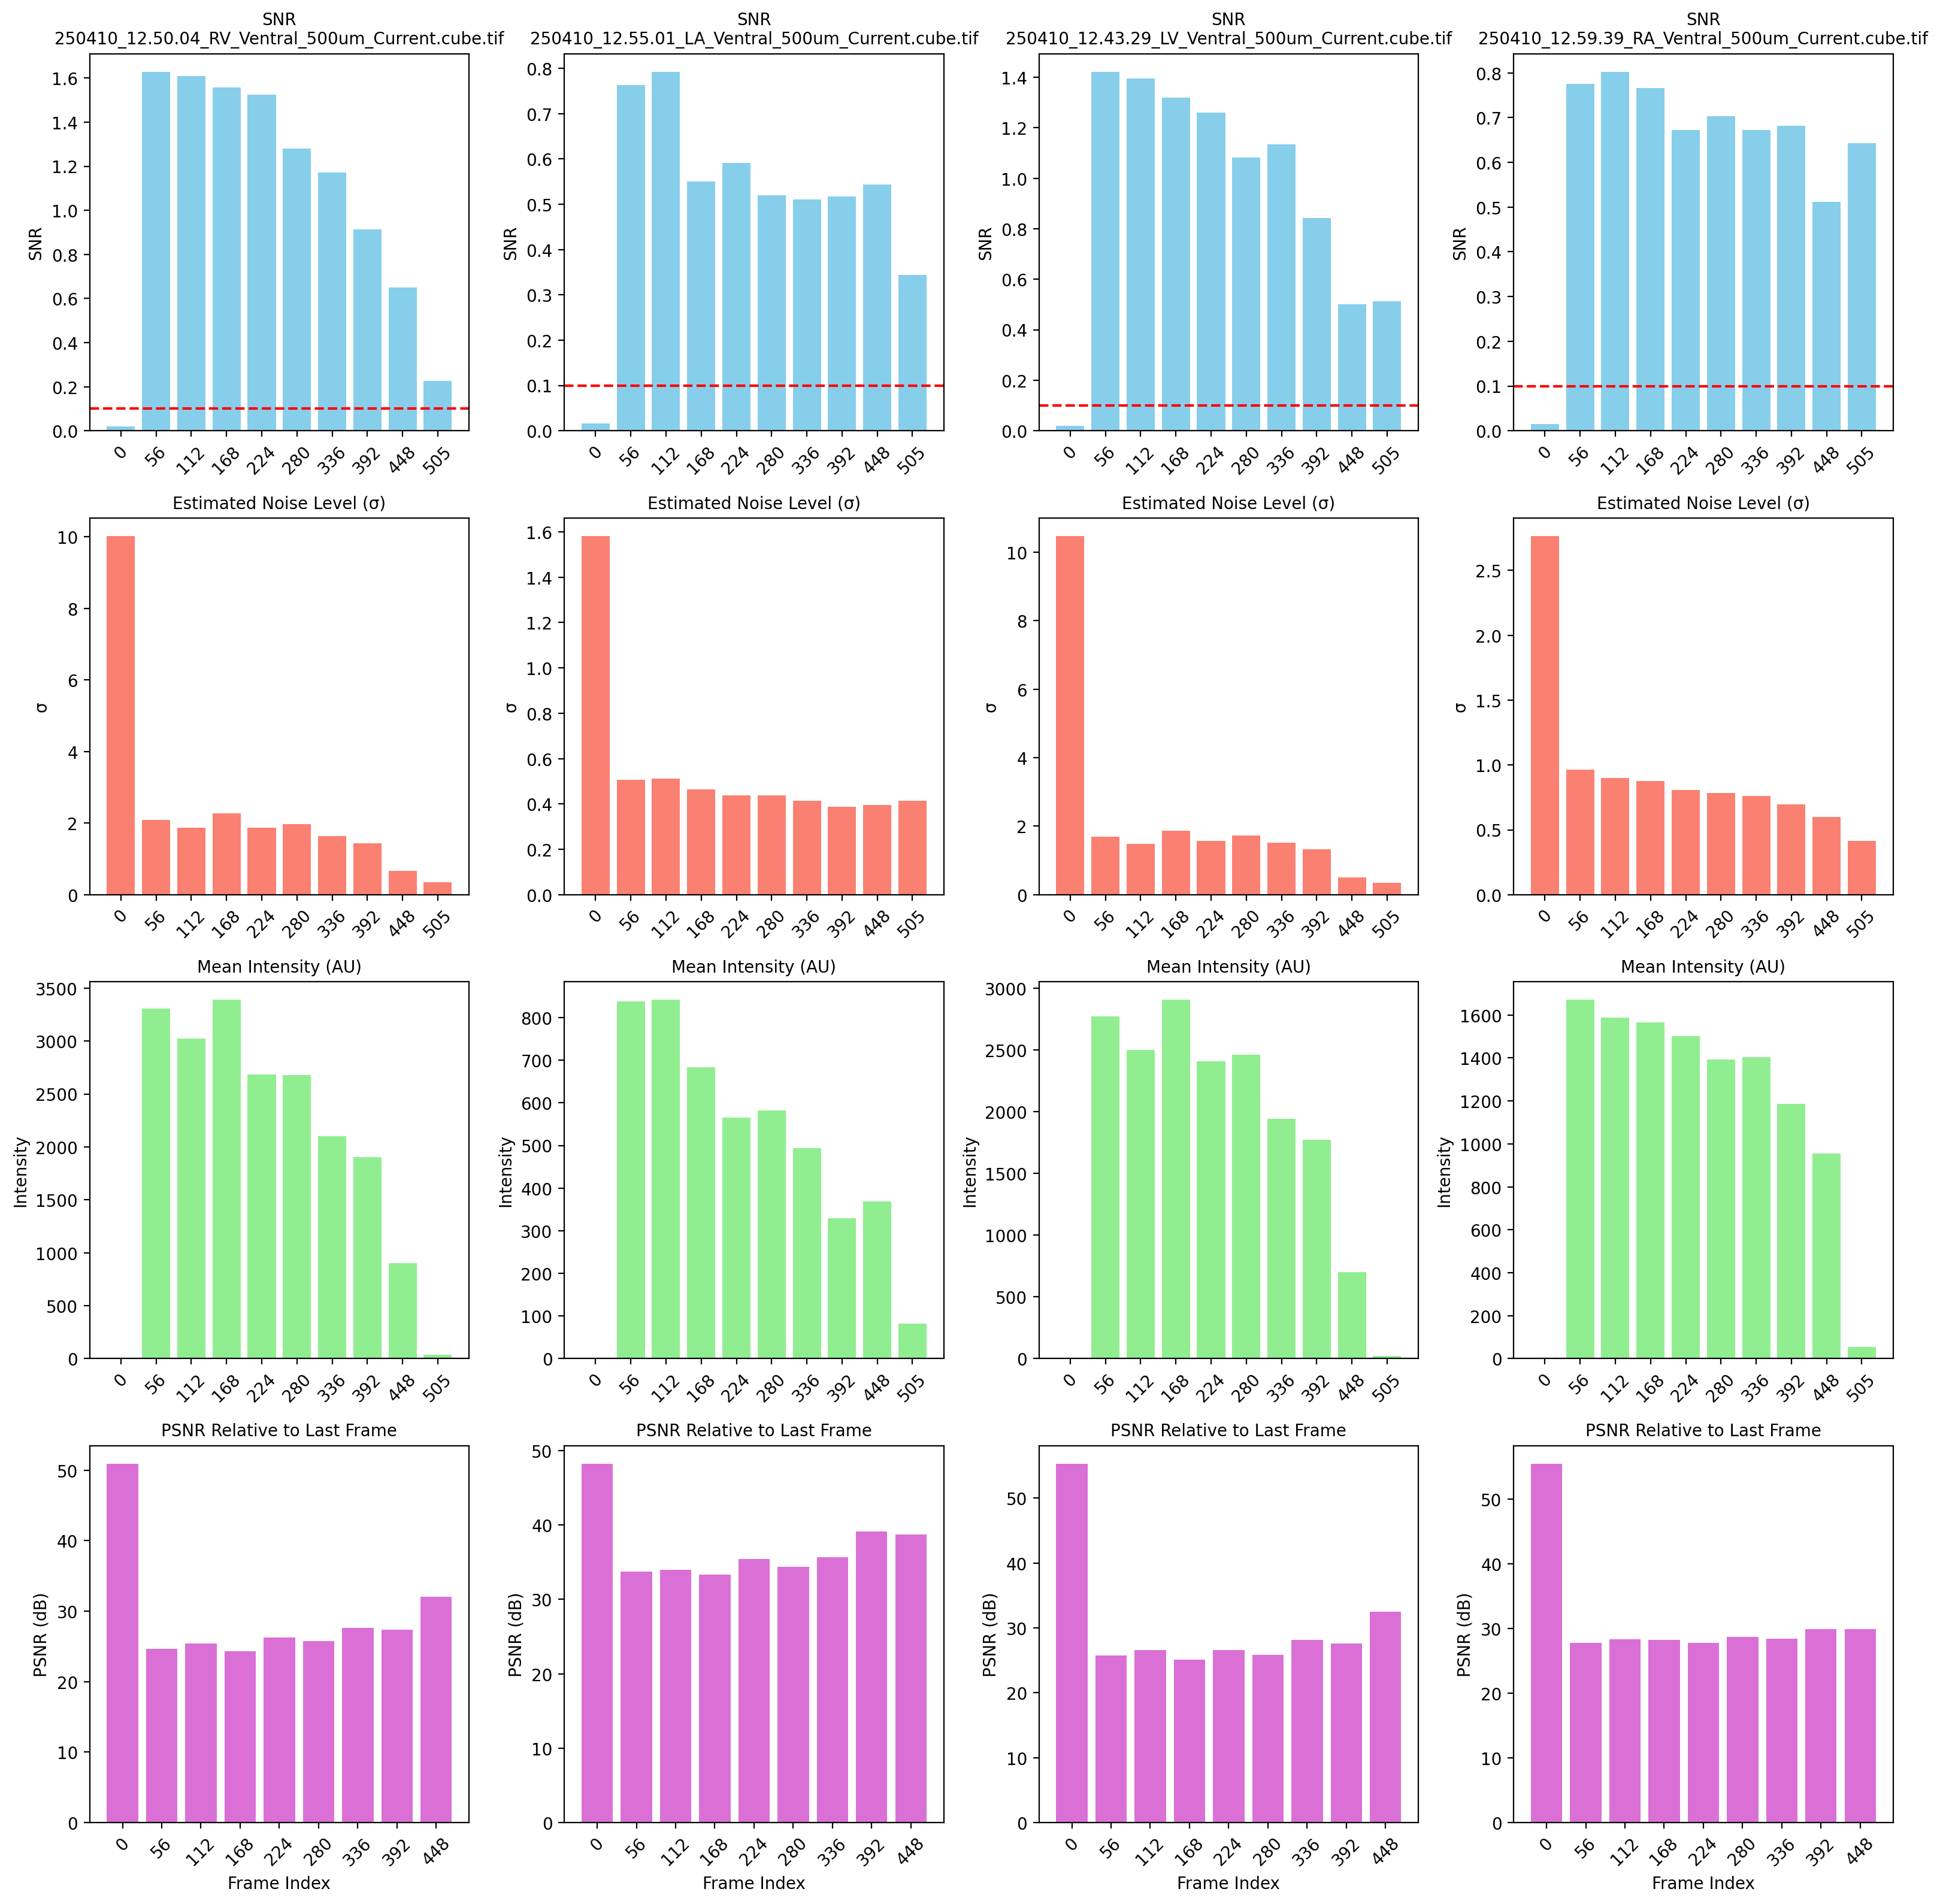

In [24]:
visualize_quality_metrics_multi(metrics_dict, total_frames_dict, max_cols=4)

In [50]:
import matplotlib.pyplot as plt

def visualize_quality_metrics_lines_2x2(metrics_dict, total_frames_dict):
    metric_names = ['snr', 'noise_level', 'mean', 'psnr_rel']
    metric_titles = [
        "Signal-to-Noise Ratio (SNR)",
        "Estimated Noise Level (σ)",
        "Mean Intensity (AU)",
        "PSNR Relative to Last Frame (dB)"
    ]
    colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red']

    filenames = list(metrics_dict.keys())
    
    fig, axs = plt.subplots(2, 2, figsize=(14, 10))
    axs = axs.flatten()

    for ax, metric_name, title, color in zip(axs, metric_names, metric_titles, colors):
        for filename in filenames:
            metrics = metrics_dict[filename]
            total_frames = total_frames_dict[filename]

            # Convert keys to frame numbers, replace -1 with last frame index
            corrected_frames = [total_frames - 1 if z == -1 else z for z in metrics.keys()]
            sorted_frames = sorted(corrected_frames)

            # Exclude last frame for PSNR as before
            if metric_name == 'psnr_rel':
                sorted_frames = [f for f in sorted_frames if f != total_frames - 1]

            values = []
            for f in sorted_frames:
                key = -1 if (f == total_frames - 1 and -1 in metrics) else f
                values.append(metrics[key][metric_name])

            ax.plot(sorted_frames, values, marker='o', label=filename)

        ax.set_title(title)
        ax.set_xlabel("Frame Index")
        ax.set_ylabel(title)
        ax.grid(False)
        ax.legend(fontsize=6, loc='best')

        if metric_name == 'snr':
            ax.axhline(0.1, color='r', linestyle='--', label='SNR threshold 0.1')

    plt.tight_layout()
    plt.show()


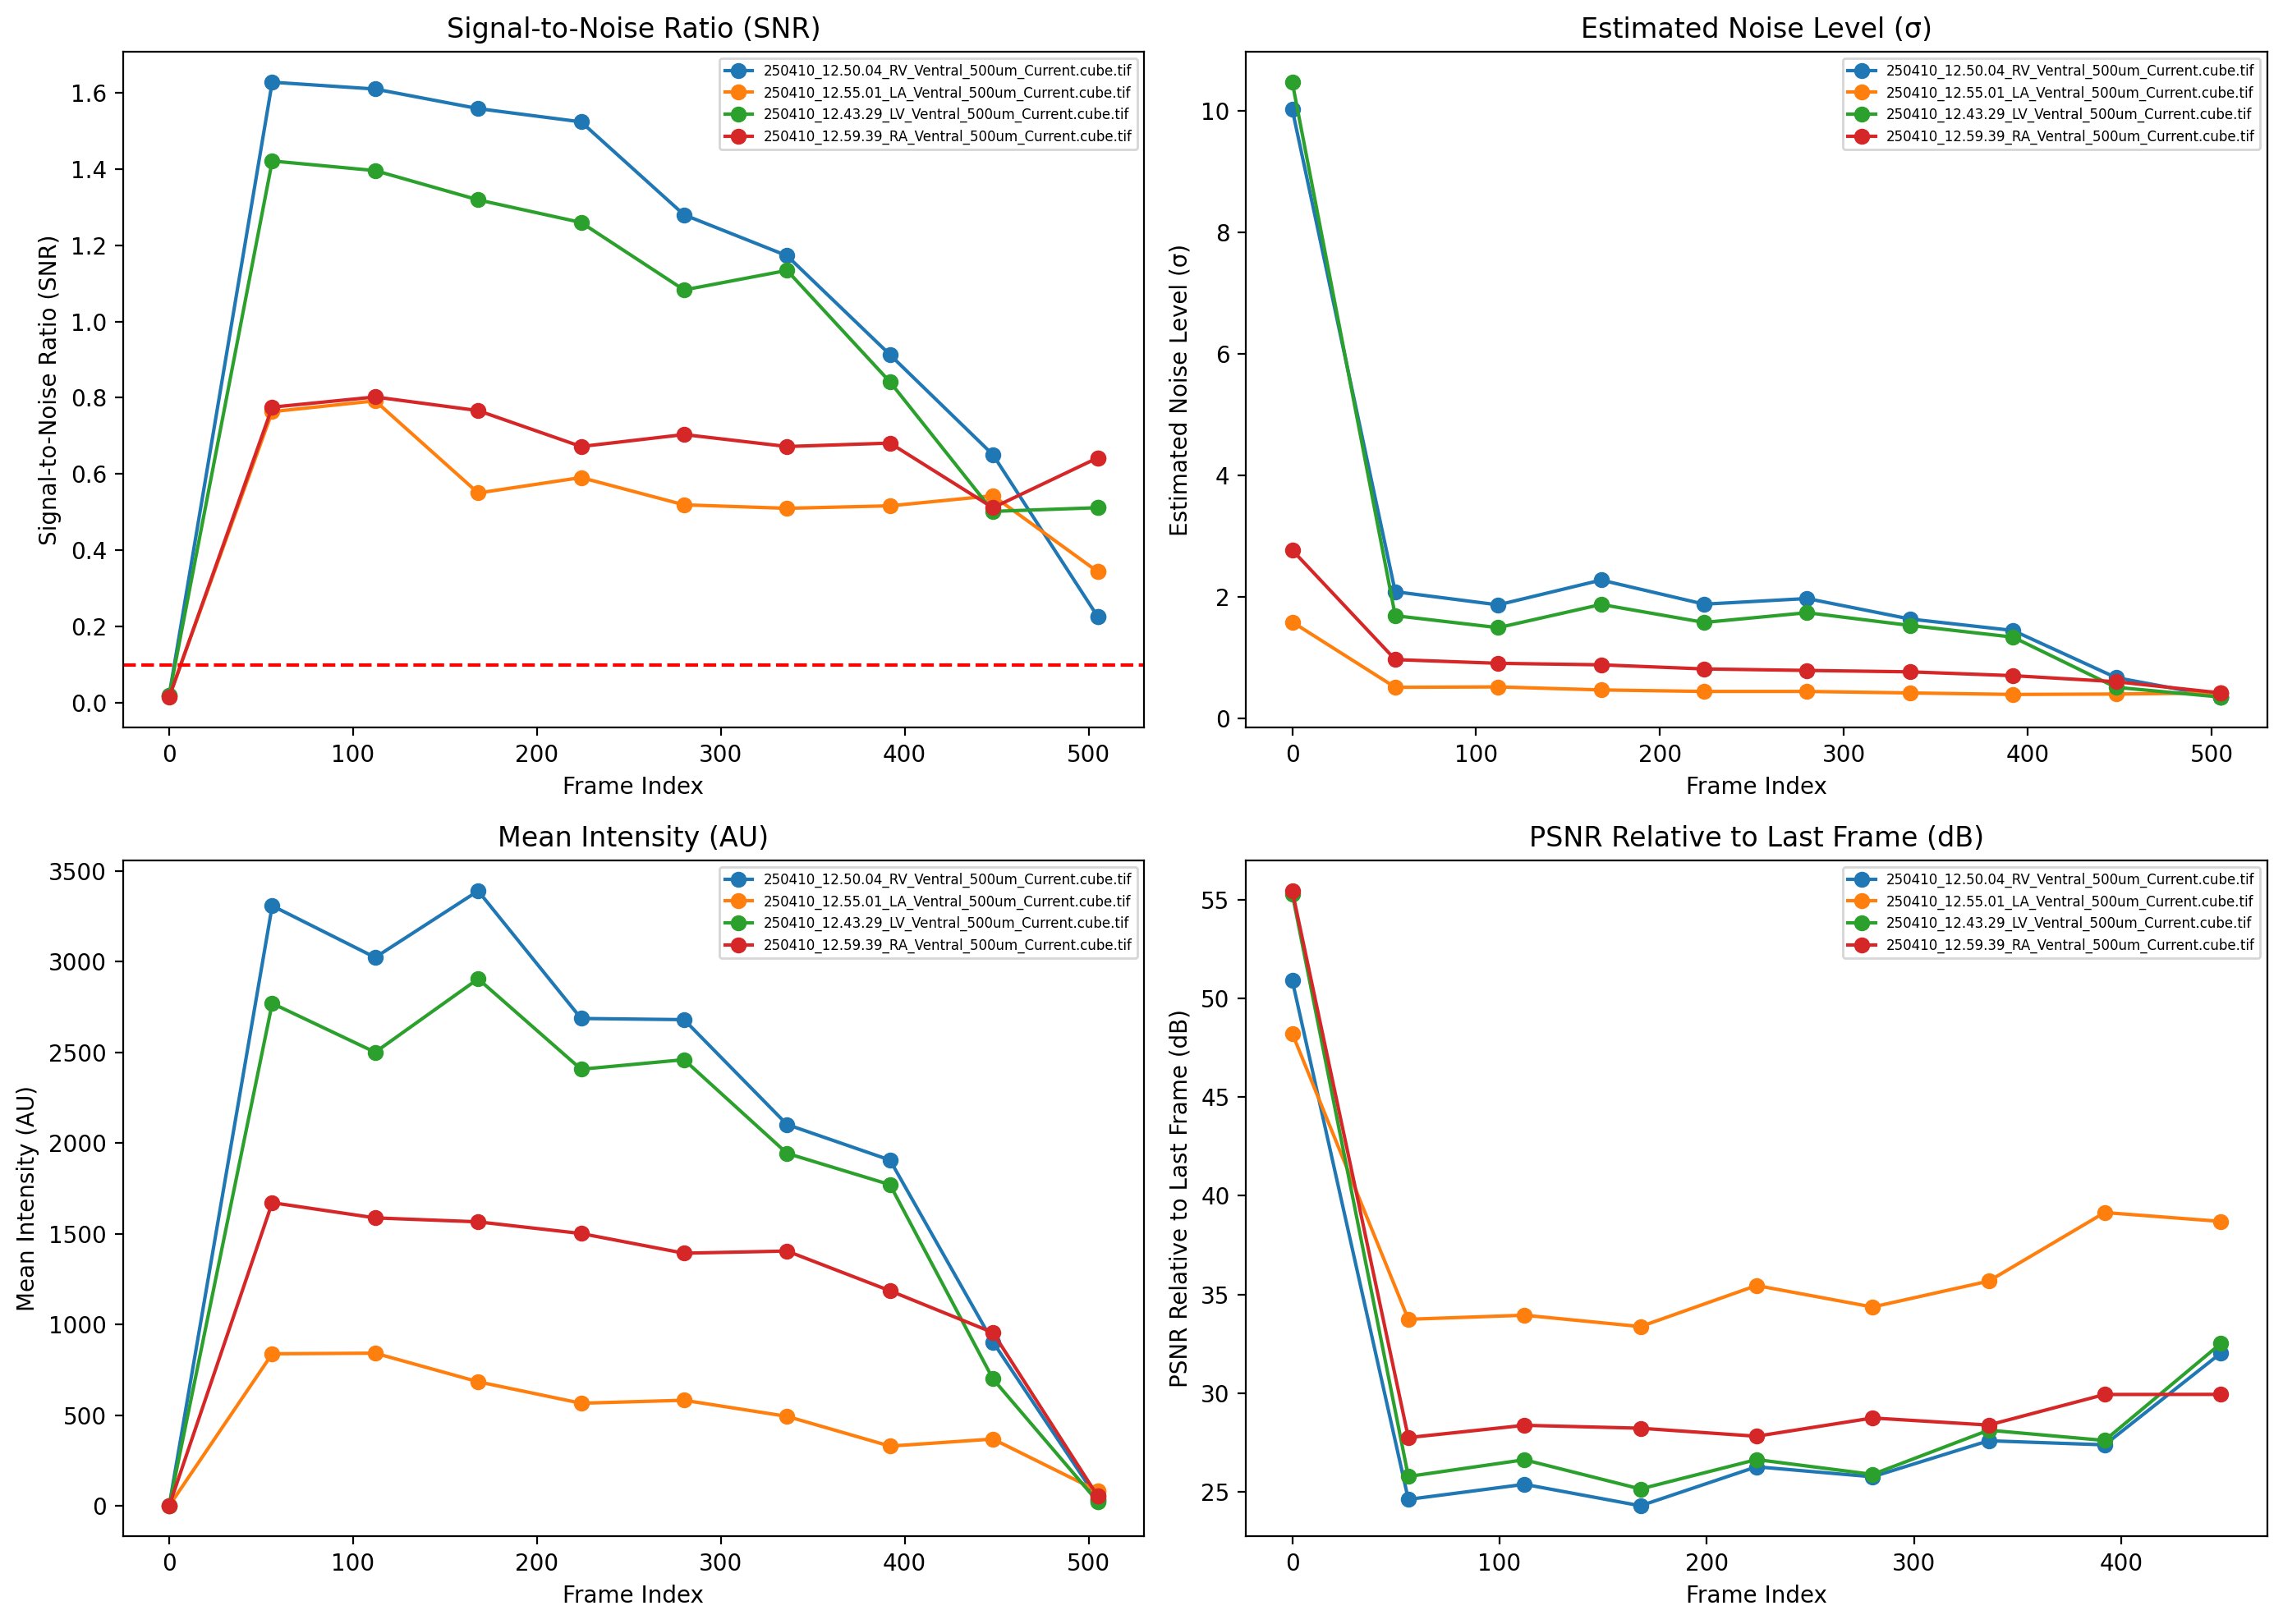

In [53]:
visualize_quality_metrics_lines_2x2(metrics_dict, total_frames_dict)

In [ ]:
metrics_dict2 = OrderedDict()
total_frames_dict2 = OrderedDict()

input_dir = "../Image_Data/E14.5_TOGF_noCre_data/Deconvolved_data/"

start_time = time.time()

print(f"🔍 Scanning directory: {input_dir}")
tif_files = [f for f in os.listdir(input_dir) if f.endswith((".tif", ".tiff"))]

for filename in tqdm(tif_files, desc="📊 Processing images", unit="file"):
    path = os.path.join(input_dir, filename)
    try:
        metrics = frame_quality_metrics(path,25)
        metrics_dict2[filename] = metrics

        with tifffile.TiffFile(path) as tif:
            total_frames_dict2[filename] = tif.asarray(out='memmap').shape[0]

    except Exception as e:
        print(f"⚠️ Error processing {filename}: {e}")

end_time = time.time()
elapsed = end_time - start_time

print(f"\n✅ Done! Processed {len(metrics_dict)} images in {elapsed:.2f} seconds.")

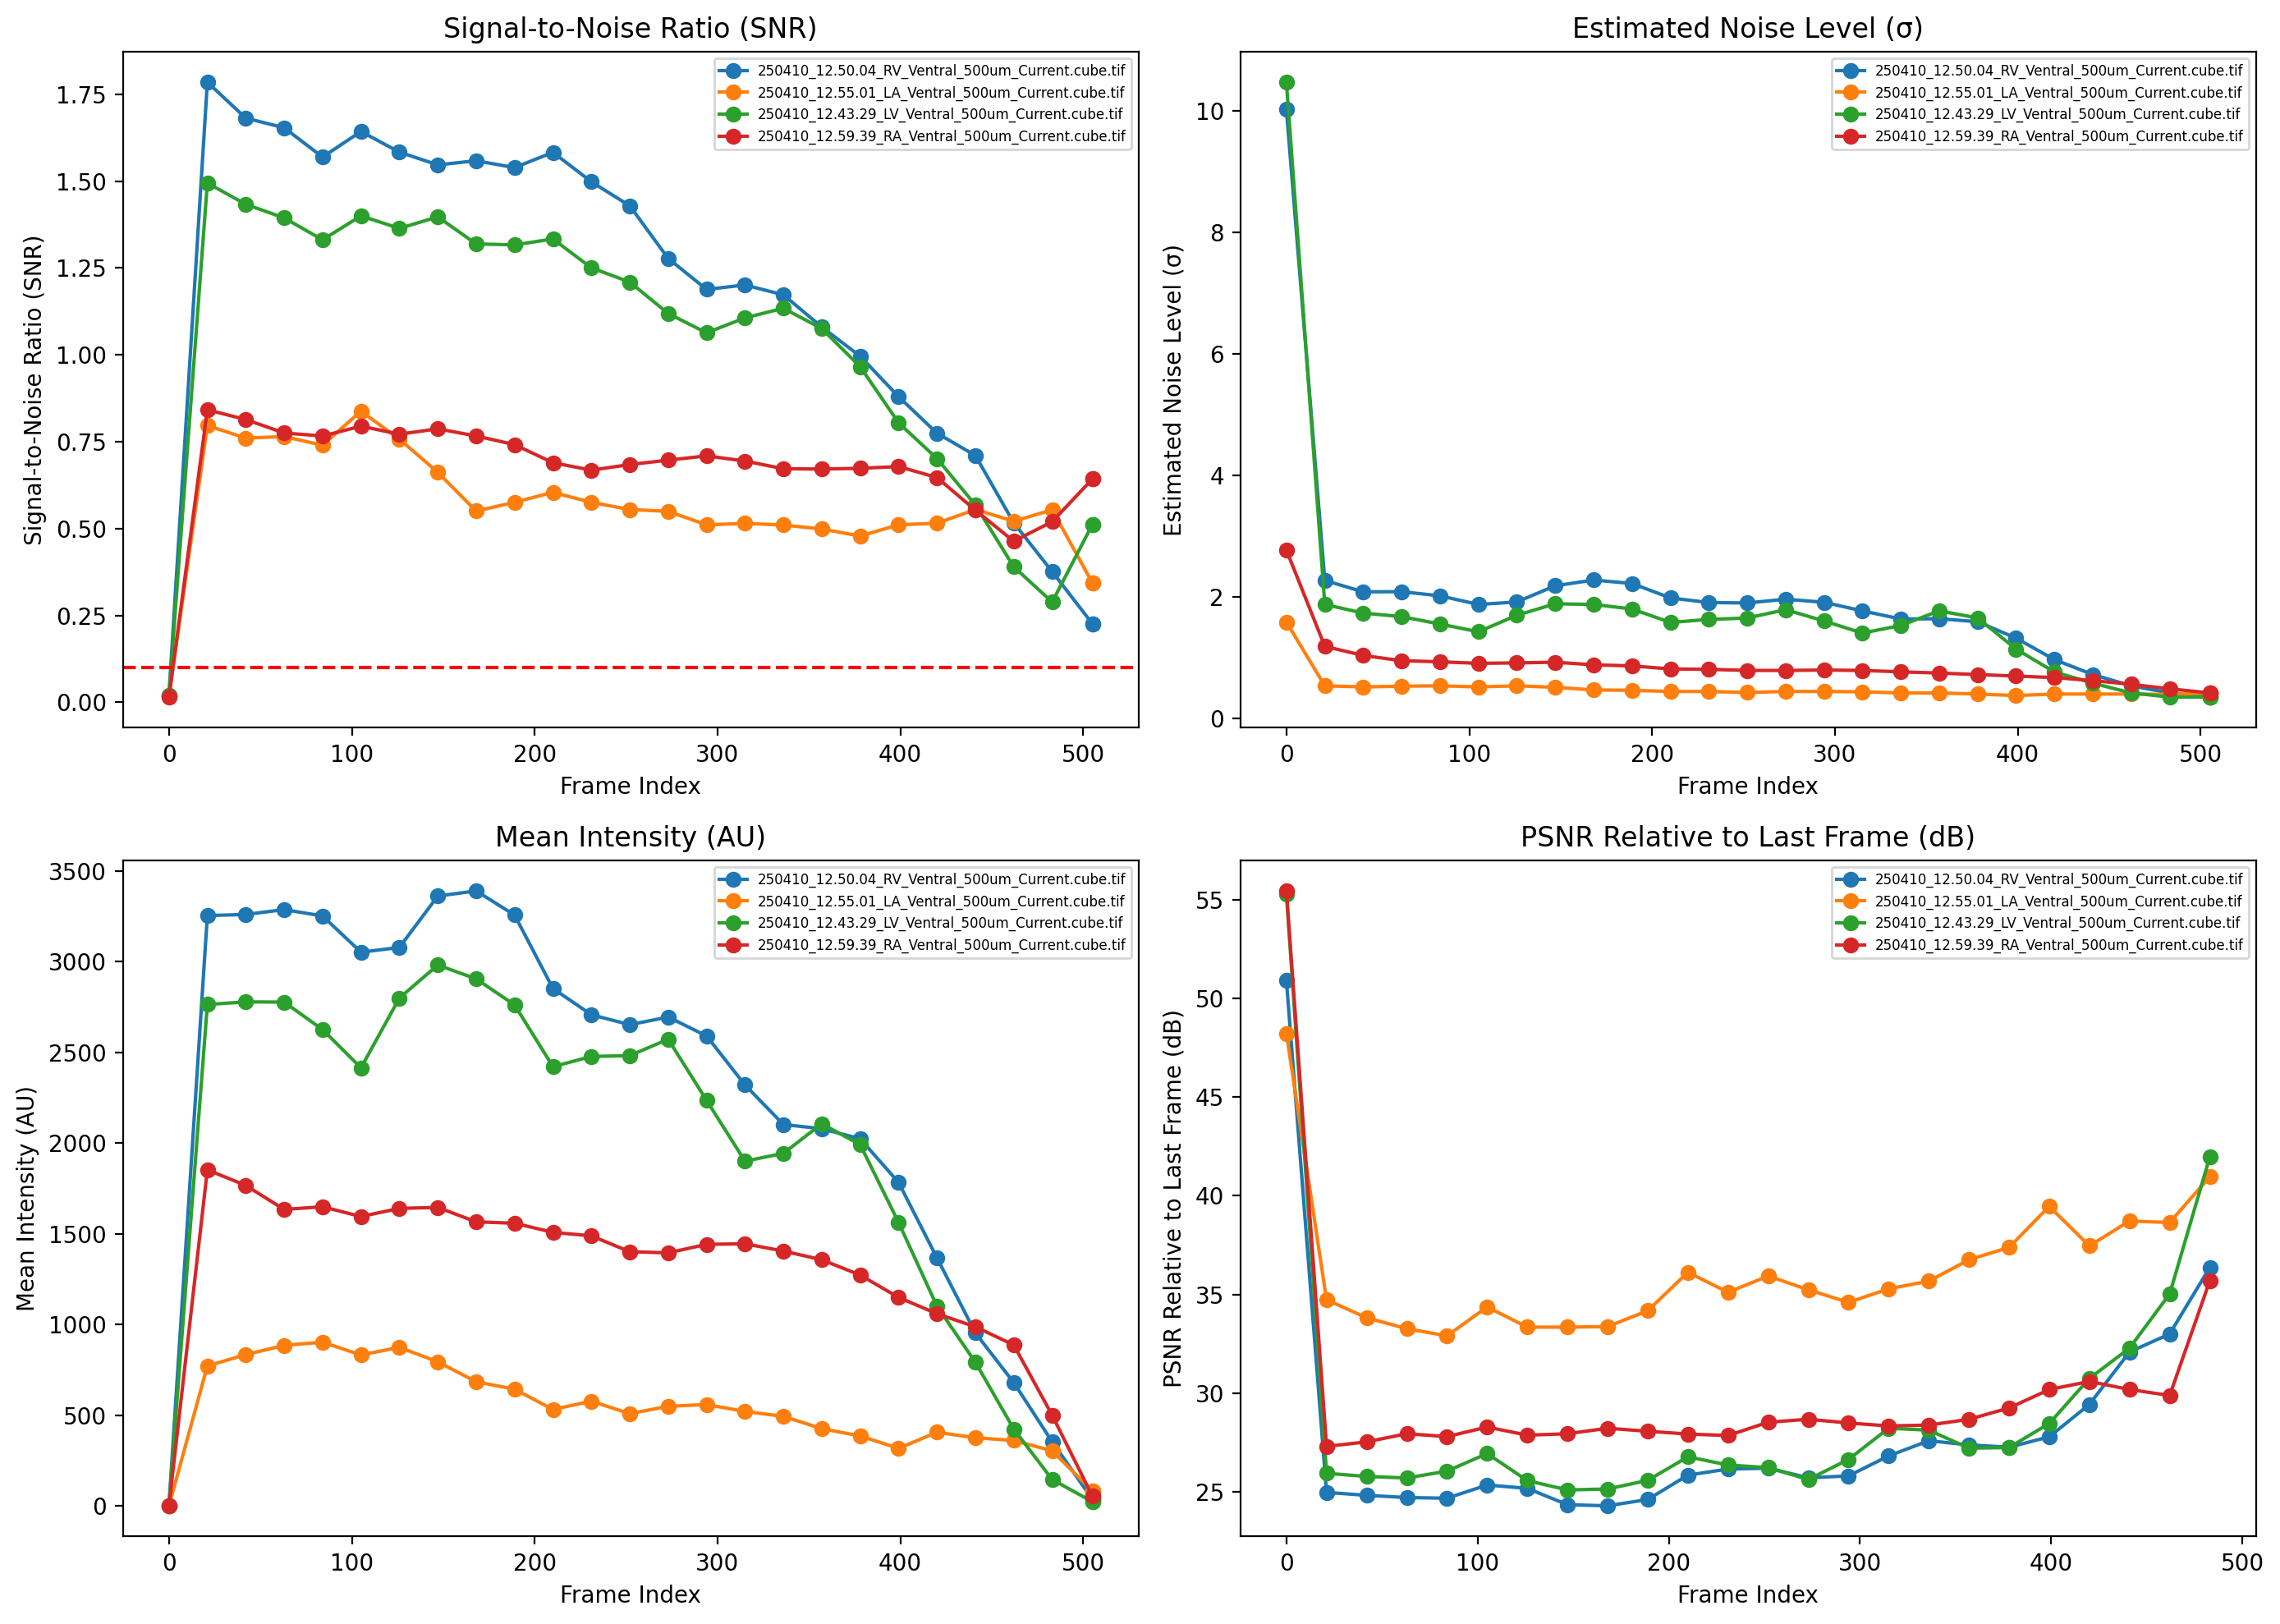

In [54]:
visualize_quality_metrics_lines_2x2(metrics_dict2, total_frames_dict2)